# Here we validate the model on a different fill: 7886

In [6]:
import torch
from data_augmentator import Data_Augmentator
from BKG_Dataholder import BKG_dataholder
from Coll_Data_Aug import Coll_Data_Augmentator


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import os
import json
import time,datetime
import tables as t

%matplotlib inline

In [7]:
BEAM_PATH = "/home/mirksonius/Desktop/Fill_info/beam/"
COLLIMATOR_PATH = "/home/mirksonius/Desktop/Fill_info/collimators/"
VACUUM_PATH = "/home/mirksonius/Desktop/Fill_info/vacuum/"
FILL_PATH = "/home/mirksonius/Desktop/22_fills/"
FILL_NUMBER = 7886#8068

vac_vars = [
    "VGI.183.1L5.X.PR",
    "VGI.183.1R5.X.PR",
    "VGI.220.1L5.X.PR",
    "VGI.220.1R5.X.PR"]

In [8]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer,MinMaxScaler

from scipy.stats import pearsonr
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD,Adam

from collimator_utils import Preprocessor,model,train,get_scores

### Loading data

In [9]:
bkg = BKG_dataholder(fill_path = FILL_PATH,
                                    fill_number = FILL_NUMBER,
                                    beam_path = BEAM_PATH,
                                   collimator_path = COLLIMATOR_PATH,
                                   vacuum_path= VACUUM_PATH  
                                 )
                                 
bkg.get_beam_data()
bkg.get_fill_data()
bkg.vacuum_variables = vac_vars
bkg.get_vacuum_data()
bkg.get_collimator_data()



Opening file 7886_354586_2206290257_2206290257.hd5
File 7886_354586_2206290257_2206290257.hd5 starts at 2022-06-29 02:59:11 and ends at 2022-06-29 03:02:00
Opening file 7886_354587_2206290257_2206290345.hd5
File 7886_354587_2206290257_2206290345.hd5 starts at 2022-06-29 03:02:01 and ends at 2022-06-29 03:47:08
Opening file 7886_354588_2206290345_2206290558.hd5
File 7886_354588_2206290345_2206290558.hd5 starts at 2022-06-29 03:47:09 and ends at 2022-06-29 06:00:15
Opening file 7886_354591_2206290558_2206290652.hd5
File 7886_354591_2206290558_2206290652.hd5 starts at 2022-06-29 06:42:04 and ends at 2022-06-29 06:53:21
Opening file 7886_354592_2206290652_2206290704.hd5
File 7886_354592_2206290652_2206290704.hd5 starts at 2022-06-29 07:01:38 and ends at 2022-06-29 07:04:26
Opening file 7886_354593_2206290704_2206290704.hd5
File 7886_354593_2206290704_2206290704.hd5 starts at 2022-06-29 07:04:27 and ends at 2022-06-29 07:06:37
Opening file 7886_354594_2206290704_2206290743.hd5
File 7886_354

In [10]:
aug = Data_Augmentator(
    bkg_dh = bkg,
    vac_vars = vac_vars
    )

Background points removed: 0
Precetnage removed: 0.0%
Luminosity points removed: 0
Precetnage removed: 0.0%


In [11]:
collimator_columns = []
for c in aug.collimators:
    for var in [aug.collimator_variables[0]]:
        collimator_columns.append(c+var)

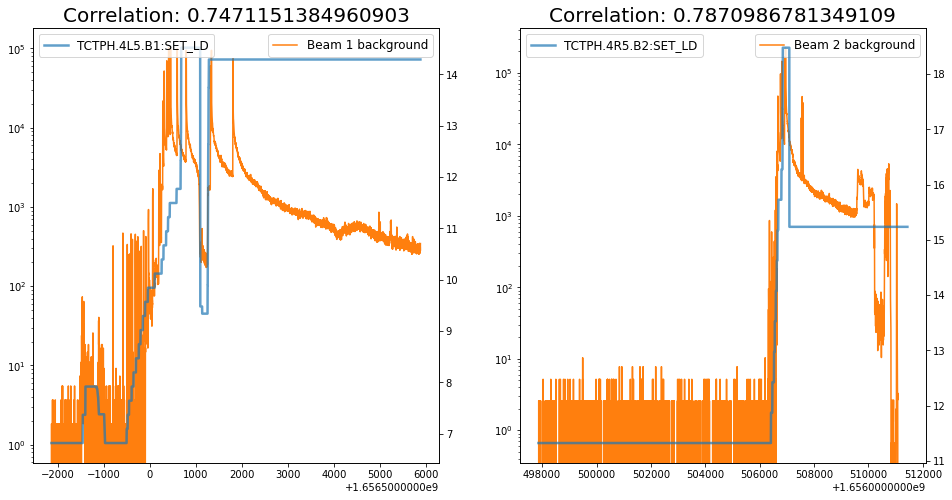

In [12]:
frame,fig = plt.subplots(1,2,figsize = (16,8))
start = 14_000

id0 = 16_000

idx = bkg.plusz[id0:id0+5500].nonzero()[0]
fig[0].plot(
    bkg.times[id0:id0+5500],
    bkg.plusz[id0:id0+5500],label = "Beam 1 background",color ="tab:orange")
fig[0].set_yscale("log")
fig[0].legend(loc = "upper right",fontsize = 12)
pearson1 = pearsonr(
    np.log(bkg.plusz[id0:id0+5500][idx]),
    aug.all_data["TCTPH.4L5.B1:SET_LD"].values[id0:id0+5500][idx],

)

fig[0].set_title(f"Correlation: {pearson1[0]}",fontsize = 20)
ax0 = fig[0].twinx()
ax0.plot(
    aug.times[id0:id0+5500],
    aug.all_data["TCTPH.4L5.B1:SET_LD"].values[id0:id0+5500],
    label ="TCTPH.4L5.B1:SET_LD",
    linewidth = 2.5,alpha = 0.7 )
ax0.legend(loc = "upper left",fontsize = 12)



idx = bkg.minusz[id0:].nonzero()[0]
pearson2 = pearsonr(
    np.log(bkg.minusz[id0:][idx]),
    aug.all_data["TCTPH.4R5.B2:SET_LD"].values[id0:][idx],

)

fig[1].set_title(f"Correlation: {pearson2[0]}",fontsize = 20)
fig[1].plot(bkg.times[id0:],bkg.minusz[id0:],label = "Beam 2 background",color ="tab:orange")
fig[1].set_yscale("log")
fig[1].legend(loc = "upper right",fontsize = 12)

ax1 = fig[1].twinx()
ax1.plot(
    aug.times[id0:],
    aug.all_data["TCTPH.4R5.B2:SET_LD"].values[id0:],
    label ="TCTPH.4R5.B2:SET_LD",
    linewidth = 2.5,alpha = 0.7 )
ax1.legend(loc="upper left",fontsize = 12)
plt.savefig("baseline_7886.png")

## Preparing quadratic features

In [9]:

plus_preprocessor = Preprocessor(
    aug.all_data[collimator_columns].values[start:],
    aug.all_data["plusz"].values[start:],
    names = collimator_columns,interaction_only=False
    )
    
plus_preprocessor.make_polynomial()
plus_preprocessor.scale_data()

pdata,ptarget = plus_preprocessor.to_torch()

minus_preprocessor = Preprocessor(
    aug.all_data[collimator_columns].values[start:],
    aug.all_data["minusz"].values[start:],
    names = collimator_columns,interaction_only=False
    )

minus_preprocessor.make_polynomial()
minus_preprocessor.scale_data()

mdata,mtarget = minus_preprocessor.to_torch()


## Loading quadratic models

In [10]:
plus_quadratic = model(
    plus_preprocessor.data.shape[1],1
)

plus_quadratic.load_state_dict(torch.load("plus_model_quadratic.pt"))

minus_quadratic = model(
    minus_preprocessor.data.shape[1],1
)

minus_quadratic.load_state_dict(torch.load("minus_model_quadratic.pt"))



<All keys matched successfully>

## Beam1 model correlation

Correlation with plusz bacgkround


Text(0.5, 1.0, 'Correlation  0.8019503919128537')

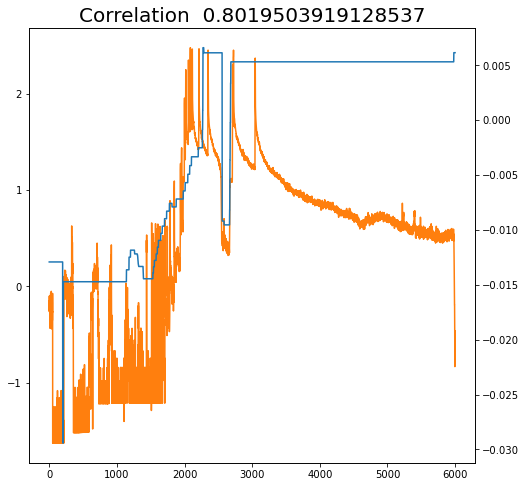

In [13]:
_,fig = plt.subplots(figsize =(8,8))
plus_quadratic.eval()

print("Correlation with plusz bacgkround")
yplus = plus_quadratic(
        pdata).detach().numpy().flatten()


idx = plus_preprocessor.idx
pear = pearsonr(
        yplus[:6000],
        #ptarget[:6000])
        np.log(aug.all_data["plusz"].values[start:][idx][:6000])
        )


fig.plot(ptarget[:6000],color ="tab:orange",)
#plt.plot(plus_preprocessor.convolve_gauss(ptarget[:6000]))
tw = fig.twinx()
tw.plot(yplus[:6000])

fig.set_title(f"Correlation  {pear[0]}",fontsize = 20)

## Beam2 model correlation

Correlation with plusz bacgkround
4276


Text(0.5, 1.0, 'Correlation: 0.8431235791106702')

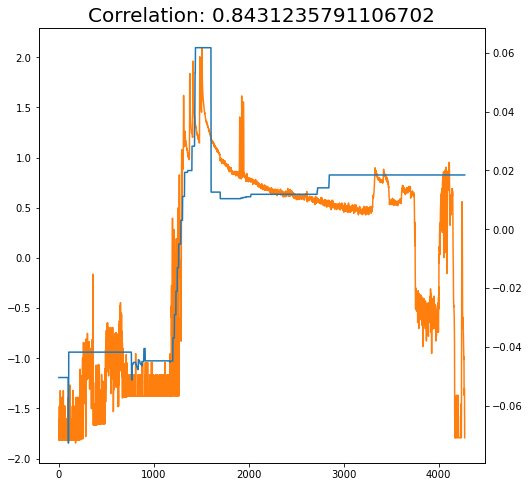

In [18]:
minus_quadratic.eval()
_,fig = plt.subplots(figsize =(8,8))

print("Correlation with plusz bacgkround")
yminus = minus_quadratic(
        mdata).detach().numpy().flatten()
print(yminus.size)
pear = pearsonr(
        yminus[:],
        mtarget[:])
        

fig.plot(mtarget[:],color ="tab:orange",)
tw = fig.twinx()
tw.plot(yminus[:])

fig.set_title(f"Correlation: {pear[0][0]}",fontsize = 20)


## Correlating some of the top Beam 1 features with bacgkround
Include other important variables!
FOR PRES: Show that modeling this way is necessary!


Text(0.5, 1.0, 'Correlation: 0.8222340904416049')

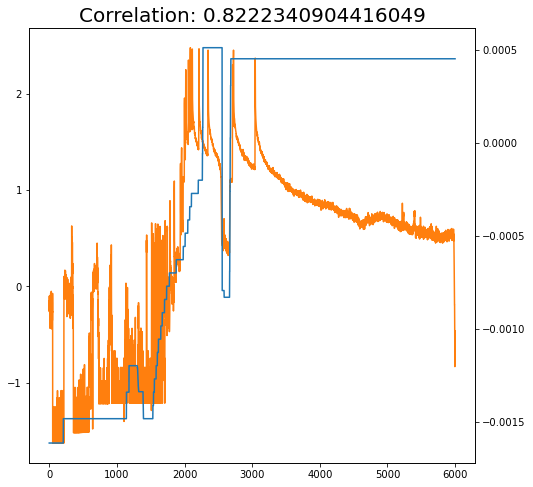

In [23]:
variables = [
    "TCTPH.4L5.B1:SET_LD^2",
    "TCTPH.4L5.B1:SET_LD TCTPV.4R5.B2:SET_LD",
    "TCTPH.4L5.B1:SET_LD TCL.5L5.B2:SET_LD"]

vars, index = plus_preprocessor.select_variables(variables = variables)
weights = plus_quadratic.linear.weight[:,index].detach().numpy()
signal = 0
weights[0]
for v,w in zip(vars,weights[0]):
    signal = -v[:6000]*w

frame,fig = plt.subplots(figsize = (8,8))
fig.plot(plus_preprocessor.target[:6000],color = "tab:orange")

corr = pearsonr(
        signal,
        plus_preprocessor.target[:6000])

tw = fig.twinx()
tw.plot(signal)
fig.set_title(f"Correlation: {corr[0][0]}",fontsize = 20)

## Correlating some of the top Beam 2 features with bacgkround

Text(0.5, 1.0, 'Correlation: 0.8671990897238192')

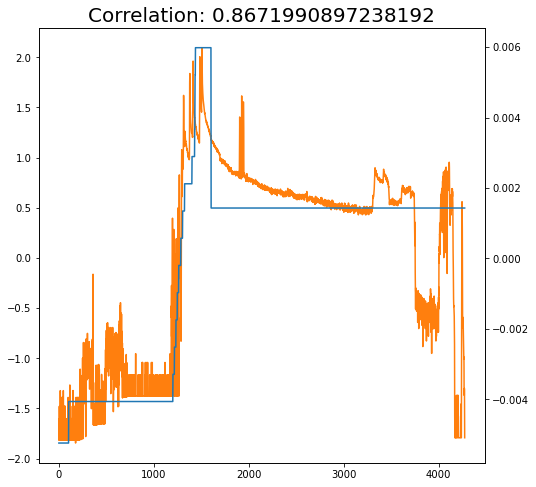

In [17]:
variables = [
    "TCTPV.4L5.B1:SET_LD TCTPH.4R5.B2:SET_LD",
    "TCTPH.4R5.B2:SET_LD^2",
    "TCTPH.4R5.B2:SET_LD TCL.4L5.B2:SET_LD"]

minus_preprocessor.names
vars, index = minus_preprocessor.select_variables(variables = variables)
weights = minus_quadratic.linear.weight[:,index].detach().numpy()
signal = 0
weights[0]
for v,w in zip(vars,weights[0]):
    signal = v*w

frame,fig = plt.subplots(figsize = (8,8))
fig.plot(minus_preprocessor.target,color = "tab:orange")

corr = pearsonr(
        signal,
        minus_preprocessor.target)

tw = fig.twinx()
tw.plot(signal)
fig.set_title(f"Correlation: {corr[0][0]}",fontsize = 20)

## Cubic features in action

PearsonRResult(statistic=0.8236948092886163, pvalue=0.0)


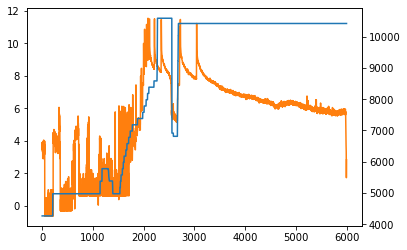

In [ ]:

frame,fig = plt.subplots(figsize=(8,8))

idx =bkg.plusz[start:].nonzero()[0]

x1 = aug.all_data["TCTPH.4L5.B1:SET_LD"].values[start:][idx]
# x2 and x3 show stay fixed!!
x2 = aug.all_data["TCL.5R5.B1:SET_LD"].values[start:][idx]
x3 = aug.all_data["TCL.6R5.B1:SET_LD"].values[start:][idx]



print(
    pearsonr(
        np.log(bkg.plusz[start:][idx][:6000]),
        x1[:6000]*x2[:6000]*x3[:6000]
    )
)


plt.plot(np.log(bkg.plusz[start:][idx][:6000]),color = "tab:orange")
plt.twinx()
plt.plot(x1[:6000]*x2[:6000]*x3[:6000])



## Linear preprocessors

In [ ]:
plus_preprocessor = Preprocessor(
    aug.all_data[collimator_columns].values[start:],
    aug.all_data["plusz"].values[start:],
    names = collimator_columns
    )
plus_preprocessor.scale_data()


minus_preprocessor = Preprocessor(
    aug.all_data[collimator_columns].values[start:],
    aug.all_data["minusz"].values[start:],
    names = collimator_columns
    )

minus_preprocessor.scale_data()


pdata,ptrain_target = plus_preprocessor.to_torch()
mdata,mtrain_target = minus_preprocessor.to_torch()


## Linear model validation

In [ ]:
plus_linear = model(
    plus_preprocessor.data.shape[1],1
)

plus_linear.load_state_dict(torch.load("plus_model_linear.pt"))

minus_linear = model(
    minus_preprocessor.data.shape[1],1
)

minus_linear.load_state_dict(torch.load("minus_model_linear.pt"))



<All keys matched successfully>

Correlation with plusz bacgkround
PearsonRResult(statistic=0.7340524464684117, pvalue=0.0)


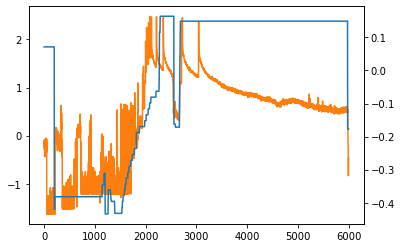

In [ ]:
plus_quadratic.eval()

print("Correlation with plusz bacgkround")
yplus = plus_linear(
        pdata).detach().numpy().flatten()


idx = plus_preprocessor.idx
print(
pearsonr(
        yplus[:6000],
        #ptarget[:6000])
        np.log(aug.all_data["plusz"].values[start:][idx][:6000])
        ))


plt.plot(ptarget[:6000],color ="tab:orange",)
#plt.plot(plus_preprocessor.convolve_gauss(ptarget[:6000]))
plt.twinx()
plt.plot(yplus[:6000])
